## Load Pickle Data

In [1]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import necessary items from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation, Dropout, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.layers.BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [2]:
# from PIL import Image
# img = plt.imread(r"/scratch1/pswaroo/data/bdd100k/labels/drivable/colormaps/val/b1c66a42-6f7d68ca.png")
# plt.imshow(img[:,:,])
# print(img.shape)
# Load training images
path = '/scratch1/pswaroo/data/curated_data/'

In [3]:
train_images = np.load(path+'images/rainy.npy')

(5070, 432, 768, 3)


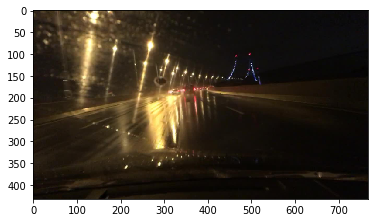

In [4]:
i = 0

scale_percent = 60 # percent of original size
width = int(train_images[0].shape[1] * scale_percent / 100)
height = int(train_images[0].shape[0] * scale_percent / 100)
dim = (width, height)
# print(height)
# X_train = np.array((train_images.shape))
X_train = np.zeros((train_images.shape[0],height,width,train_images.shape[3]))

for image in train_images:
    resize = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    X_train[i] = resize / 255
    i +=1

train_images = np.asarray(X_train)
print(train_images.shape)
plt.imshow(train_images[0])

In [5]:
# np.save("/scratch1/pswaroo/data/rainy_normalized",train_images)

In [6]:
train_labels = np.load(path+'final_data/archives/Labels/rainy_labels.npy')
y_train = np.zeros((train_labels.shape[0],height,width))
i = 0
for label in train_labels:
    label = label / 94
    y_train[i] = cv2.resize(label, dim, interpolation = cv2.INTER_NEAREST)
    i += 1

train_labels = np.asarray(y_train)
print(train_labels.shape)

(5070, 432, 768)


In [7]:
# np.unique(train_labels[86])

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
## filter_size = (5, 5)
# activation_type = 'relu'
pool_size = (2,2)

model = tf.keras.Sequential()
# model = Sequential()
# Normalizes incoming inputs. First layer needs the input shape to work
# model.add(BatchNormalization(input_shape=(720,1280,3)))
# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
model.add(layers.Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1', input_shape=(432,768,3)))

# Conv Layer 2
model.add(layers.Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

# Pooling 1
model.add(layers.MaxPooling2D(pool_size=pool_size))

# Conv Layer 3
model.add(layers.Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
model.add(layers.Dropout(0.2))

# Conv Layer 4
model.add(layers.Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
model.add(layers.Dropout(0.2))

# Conv Layer 5
model.add(layers.Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
model.add(layers.Dropout(0.2))

# Pooling 2
model.add(layers.MaxPooling2D(pool_size=pool_size))

# Conv Layer 6
model.add(layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
model.add(layers.Dropout(0.2))

# Conv Layer 7
model.add(layers.Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
model.add(layers.Dropout(0.2))

# Pooling 3
model.add(layers.MaxPooling2D(pool_size=pool_size))

# Upsample 1
model.add(layers.UpSampling2D(size=pool_size))

# Deconv 1
model.add(layers.Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
model.add(layers.Dropout(0.2))

# Deconv 2
model.add(layers.Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
model.add(layers.Dropout(0.2))

# Upsample 2
model.add(layers.UpSampling2D(size=pool_size))

# Deconv 3
model.add(layers.Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
model.add(layers.Dropout(0.2))

# Deconv 4
model.add(layers.Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
model.add(layers.Dropout(0.2))

# Deconv 5
model.add(layers.Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
model.add(layers.Dropout(0.2))

# Upsample 3
model.add(layers.UpSampling2D(size=pool_size))

# Deconv 6
model.add(layers.Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

# Final layer - only including one channel so 1 filter
model.add(layers.Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))




In [10]:
batch_size = 16
epochs = 10
# datagen = ImageDataGenerator(channel_shift_range=0.2)
X_train = train_images
y_train = train_labels
# datagen.fit(X_train)

model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=batch_size, steps_per_epoch=len(train_images)/batch_size,epochs=epochs)
model.save("DL_10EPOCH_RAINY_ACCURACY_NOCHANGE")
# # Freeze layers since training is done
# model.trainable = False
# model.compile(optimizer='Adam', loss='mean_squared_error')

Epoch 1/10
316/316 [==============================] - 91s 260ms/step - loss: 0.1021 - accuracy: 0.8804
Epoch 2/10
316/316 [==============================] - 78s 245ms/step - loss: 0.0899 - accuracy: 0.8807
Epoch 3/10
316/316 [==============================] - 78s 246ms/step - loss: 0.0871 - accuracy: 0.8822
Epoch 4/10
316/316 [==============================] - 78s 245ms/step - loss: 0.0856 - accuracy: 0.8842
Epoch 5/10
316/316 [==============================] - 77s 244ms/step - loss: 0.0844 - accuracy: 0.8842
Epoch 6/10
316/316 [==============================] - 78s 245ms/step - loss: 0.0819 - accuracy: 0.8878
Epoch 7/10
316/316 [==============================] - 77s 243ms/step - loss: 0.0806 - accuracy: 0.8900
Epoch 8/10
316/316 [==============================] - 78s 245ms/step - loss: 0.0793 - accuracy: 0.8907
Epoch 9/10
316/316 [==============================] - 78s 246ms/step - loss: 0.0777 - accuracy: 0.8926
Epoch 10/10
316/316 [==============================] - 77s 243ms/step - l

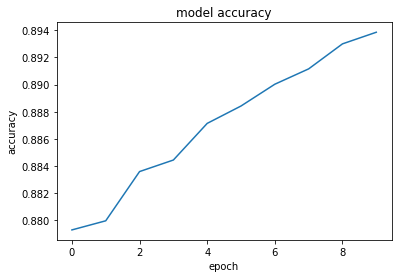

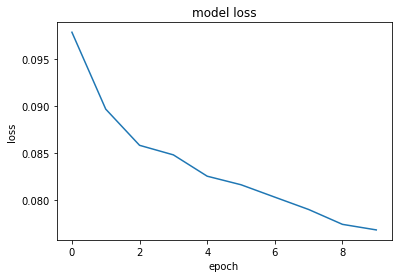

In [11]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("DL_10EPOCH_RAINY_ACCURACY_NOCHANGE")
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("DL_10EPOCH_RAINY_LOSS_NOCHANGE")

In [1]:
from sklearn.metrics import confusion_matrix

import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import necessary items from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation, Dropout, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.layers.BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [2]:
def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels = [0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [3]:
path = '/scratch1/pswaroo/data/curated_data/'

test_images = np.load(path+'images/foggy.npy')

scale_percent = 60 # percent of original size
width = int(test_images[0].shape[1] * scale_percent / 100)
height = int(test_images[0].shape[0] * scale_percent / 100)
dim = (width, height)


X_test = np.zeros((test_images.shape[0],height,width,test_images.shape[3]))

i=0
for image in test_images:
    image = image / 255
    X_test[i] = cv2.resize(image, dim, interpolation = cv2.INTER_NEAREST)
    i +=1

model = tf.keras.models.load_model('DL_10EPOCH_RAINY_ACCURACY_NOCHANGE/')
y_pred = model.predict(X_test)

In [4]:
y_pred[y_pred <= 0.6] = 0
y_pred[y_pred > 0.6] = 1

In [5]:
path = '/scratch1/pswaroo/data/curated_data/'

test_labels = np.load(path+'final_data/archives/Labels/foggy_labels.npy')

scale_percent = 60 # percent of original size
width = int(test_labels[0].shape[1] * scale_percent / 100)
height = int(test_labels[0].shape[0] * scale_percent / 100)
dim = (width, height)


Y_test = np.zeros((test_labels.shape[0],height,width))

i=0
for image in test_labels:
    image = image / 94
    Y_test[i] = cv2.resize(image, dim, interpolation = cv2.INTER_NEAREST)
    i +=1

In [6]:
y_true=Y_test
# test_labels = np.load(path+'final_data/archives/Labels/foggy_labels.npy')
print(np.unique(y_pred[29]))

[0. 1.]


In [7]:
# print(compute_iou(y_pred[1], y_true[1]))
# # train_labels.shape
m_iou = []
for i in range(130):
    m_iou.append(compute_iou(y_pred[i], y_true[i]))
    print(i)


/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-5.1.0-c3p5et4cpo7jaiahacqa3pqwhop7tiik/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-5.1.0-c3p5et4cpo7jaiahacqa3pqwhop7tiik/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
nan


In [15]:
print(np.nanmean(m_iou))

0.4840061407290205


In [ ]:
import
path = '/scratch1/pswaroo/data/curated_data/'

test_labels = np.load(path+'final_data/archives/Labels/foggy_labels.npy')